<a href="https://colab.research.google.com/github/sbbwoy/ESAA/blob/main/220329_Titanic_with__ensemble_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Titanic with ensemble modeling

1. Intorduction
2. Load and check data

    2.1 load data

    2.2 Outlier detection

    2.3 joining train and test set

    2.4 check for null and missing values
3. Feature analysis

    3.1 Numerical values
    
    3.2 Categorical values

4. Filling missing Values

    4.1 Age

5. Feature engineering

    5.1 Name/Title

    5.2 Family Size

    5.3 Cabin

    5.4 Ticket

6. Modeling

    6.1 Simple modeling
        6.1.1 Cross validate models
        6.1.2 Hyperparamater tunning for best models
        6.1.3 Plot learning curves
        6.1.4 Feature importance of the tree based classifiers

    6.2 Ensemble modeling
        6.2.1 Combinging models
    6.3 Prediction
        6.3.1 Predict and Submit results


##1. Introduction

* Feature analysis
* Feature engineering
* Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

##2. Load and check data

###2.1 Load data

In [2]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
IDtest = test['PassengerId']

###2.2 Outlier detection

In [3]:
def detect_outliers(df, n, features):
    '''
    Takes a dataframe df of features and returns a list of the indices
    correspoding to the observations containing more than n outliers accoring
    to the Tukey metho.
    '''
    outlier_indices = []

    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1   #Interquartile range

        # Determine a list of indeces of outliers for feature col
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

        #append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    #select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    return multiple_outliers

In [4]:
#detect outliers from Age, SibSp, Parch and Fare

Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

outlier는 회귀 문제에서 특히 영향이 크기 때문에 관리해야 함

Tukey method를 outliers 감지를 위해 사용

- interquartile range(Q1-Q3)를 정의해서, outlier는 IQR +- outlier step 밖에 있는 값을 가진 행

최소 두 개의 outlied numerical values를 가진 행을 outlier로 분류함

In [5]:
train.loc[Outliers_to_drop] #show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 outlier를 확인. 28, 89, 342 passenger는 high ticket feare를 가지고, 나머지는 very high values of SibSP를 가짐.

In [6]:
#drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

###2.3 joing train and test set

In [7]:
#categorical conversion 동안 같은 특성치 수를 가지기 위해 train set과 test set을 연결

train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

###2.4 check for null and missing values

In [8]:
# Fill empty and Nans values with NaN
dataset = dataset.fillna(np.nan)

#Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

생존자 column은 test set에 존재하지 않아 train, test set에 연결할 때 NaN values로 대체

In [9]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [12]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


##3. Feature analysis

###3.1 Numerical values

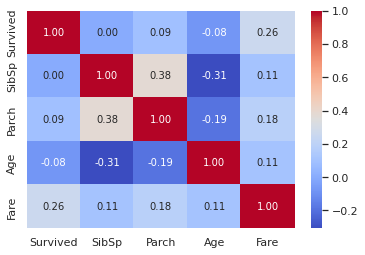

In [13]:
#상관계수 행렬 Correlation matirx

g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt = '.2f', cmap = 'coolwarm')

Fare feature만 survival probabilty와 유의한 상관관계를 보임

다른 feature가 유용하지 않다는 건 아님. 이 특성들의 표본집단은 survival과 관계가 있을 수 있음.

**SibSP**

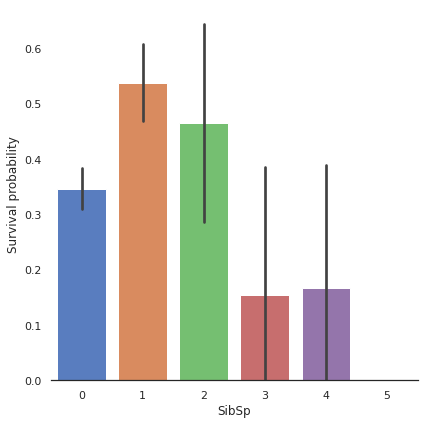

In [14]:
# Explore SibSp feature vs. Survived

g = sns.catplot(x = 'SibSp', y = 'Survived', data = train, kind = 'bar', height = 6, palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('Survival probability')

많은 siblings/spouses가 있는 passenger들은 낮은 survive를 보임

single passengers (0 SibSp)나 두어 명의 siblings이 있을 경우 더 높은 survive를 확인

**Parch**

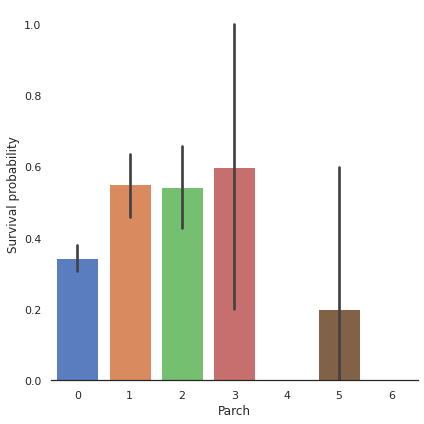

In [15]:
g = sns.catplot(x = 'Parch', y = 'Survived', data = train, kind = 'bar', height = 6, palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('Survival probability')

* Large families < Single < Small families 

* Parch 3의 std가 유독 큼

**Age**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


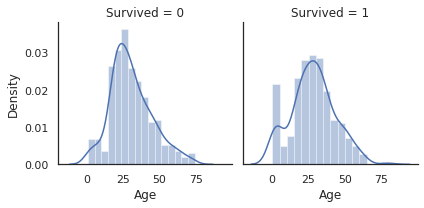

In [16]:
g = sns.FacetGrid(train, col = 'Survived')
g = g.map(sns.distplot, 'Age')

* Age 분포는 가우시안 분포로 보임
* 생존자와 사망자의 age 분포가 다름. 특히 young passengers이 살아남을 확률이 높았음. 60-80대는 낮은 확률을 보임

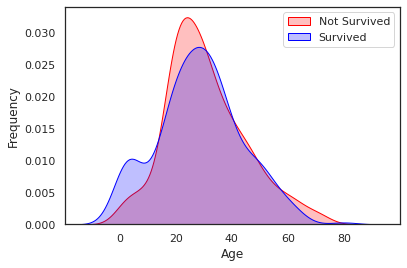

In [17]:
g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())], ax=g, color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

**Fare**

In [18]:
dataset['Fare'].isnull().sum()

1

In [19]:
#1개만 있어서 중간값으로 대체함
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


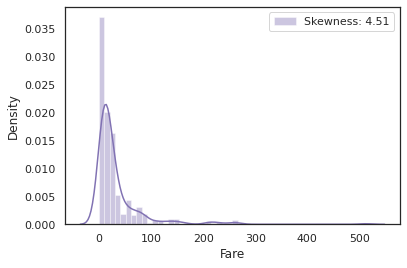

In [20]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

* Fare 분포가 매우 치우침. scaling을 거쳐도 모델에 overweigth를 가져올 수 있음

-> log function 으로 transform 해서 skew를 줄이기

In [21]:
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


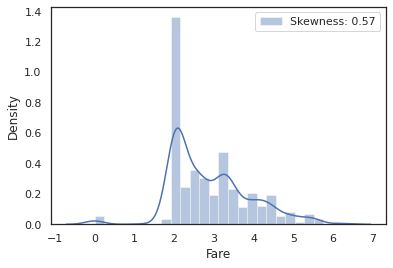

In [22]:
g = sns.distplot(dataset['Fare'], color='b', label = 'Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

log transformation 이후 줄어든 skewness를 볼 수 있음

###3.2 Categorical values

**Sex**

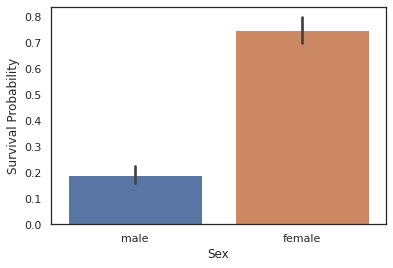

In [23]:
g = sns.barplot(x='Sex', y='Survived', data = train)
g = g.set_ylabel('Survival Probability')

In [24]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


* 남자가 생존할 확률이 현저하게 낮음
* 그러므로, Sex는 생존확률에 큰 영향을 미침

**Pclass**

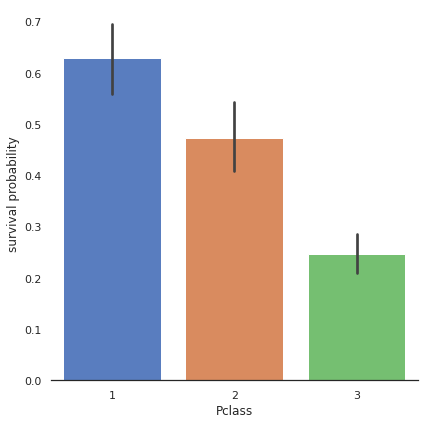

In [25]:
g = sns.catplot(x = 'Pclass', y = 'Survived', data = train, kind = 'bar', height = 6, palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

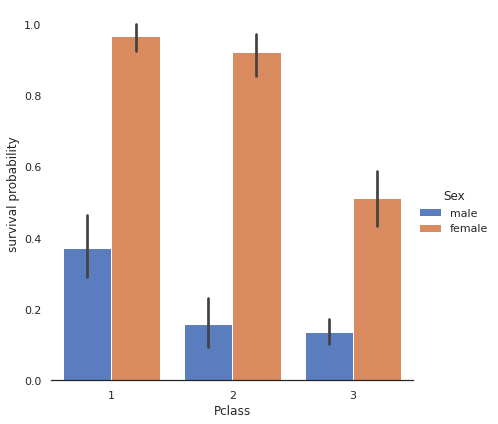

In [26]:
g = sns.catplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = train, height = 6, kind = 'bar', palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

class 1의 passenger가 더 생존확률이 높음

**Embarked**

In [27]:
dataset['Embarked'].isnull().sum()

2

In [28]:
#두 개만 있어서 최빈값으로 대체
dataset['Embarked'] = dataset['Embarked'].fillna('S')

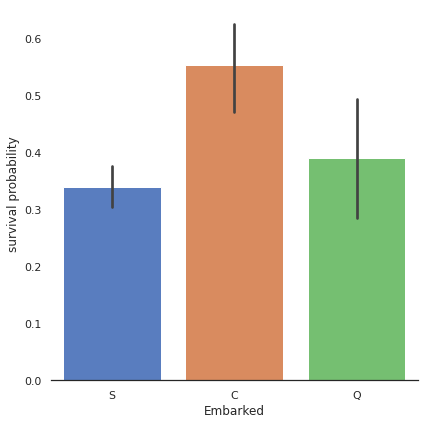

In [29]:
g = sns.catplot(x = 'Embarked', y = 'Survived', data = train, height = 6, kind = 'bar', palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

* Cherbourg(C)에서 온 승객이 더 높은 생존확률을 보임
* 가정: first class의 승객의 비율이 Cherbourg가 높지 않았을까?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


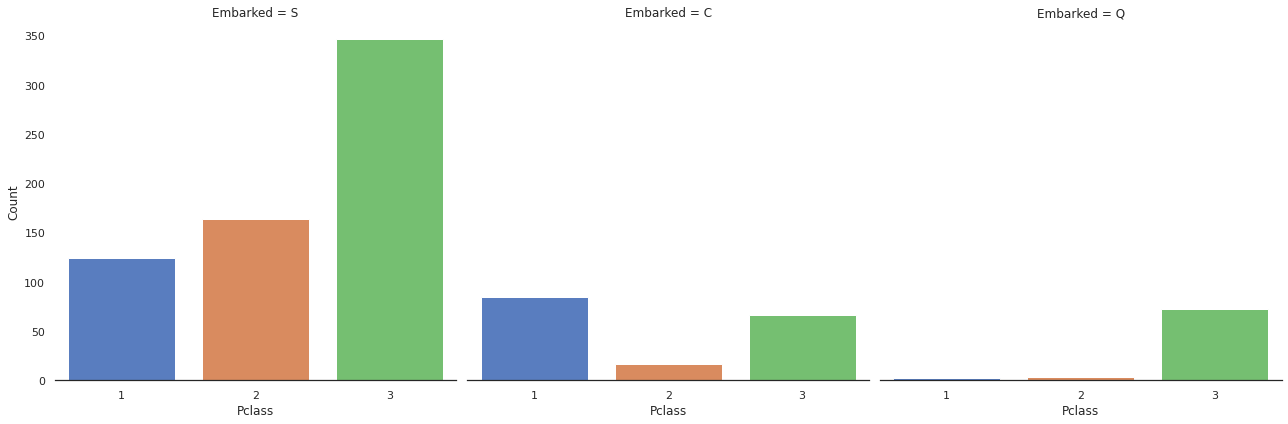

In [30]:
g = sns.catplot('Pclass', col = 'Embarked', data = train, height = 6, kind = 'count', palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('Count')

* 실제로 Southampto(S)와 Queenstown(Q)에서 온 승객은 third class에 많았음
* first class에는 Cherbourg 승객의 비율이 높음
* 질문: 왜 first class의 생존확률이 높을까?
* 가설: first class 승객이 그들의 영향력에 따라 대피 순위에서 우위를 점하지 않았을까?

##4. Filling missing Values

###4.1 Age

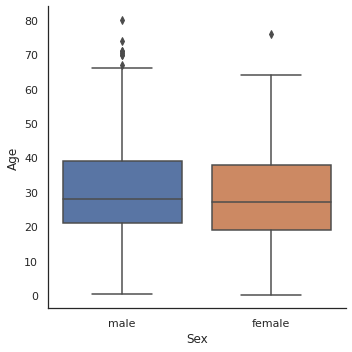

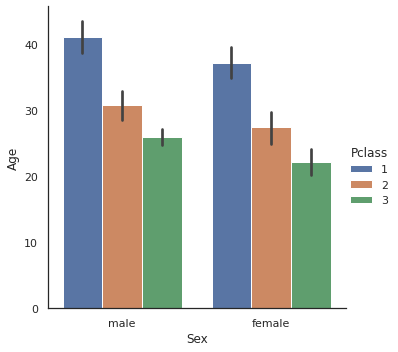

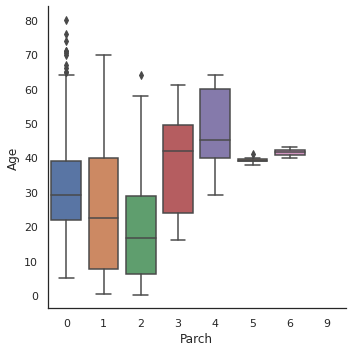

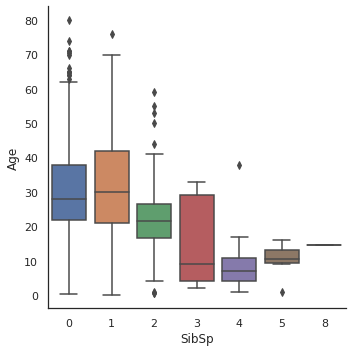

In [31]:
g = sns.catplot(x = 'Sex', y = 'Age', data = dataset, kind = 'box')
g = sns.catplot(x = 'Sex', y = 'Age', hue = 'Pclass', data = dataset, kind = 'bar')
g = sns.catplot(x = 'Parch', y = 'Age', data = dataset, kind = 'box')
g = sns.catplot(x = 'SibSp', y = 'Age', data = dataset, kind = 'box')

* Age distribution에서 두 성별의 분포가 같게 나옴.
* age - sex로 예측 X
* 1st class 승객의 나이 > 2nd class > 3rd class
* 동승자가 많을수록 승객은 나이가 많고 어린 형제가 있음

In [32]:
#convert sex into categorical value 0 for male and 1 for female
dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1})

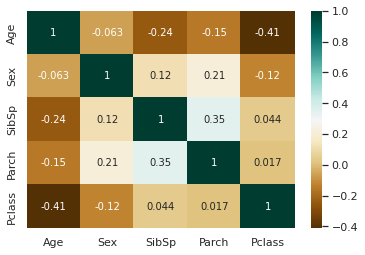

In [33]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap = 'BrBG', annot = True)

* age - sex 사이 상관관계는 낮음
* age - pclass, parch, sibsp에 대해서는 음의 상관관계를 보임
* age는 동승자의 수에 비례하지만 음의 상관관계 보임
* SibSp, Parch, and Pclass로 missing age data를 채울 예정

In [35]:
#Filling missing value of Age

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows

index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) 
    & (dataset['Parch'] == dataset.iloc[i]["Parch"]) 
    & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


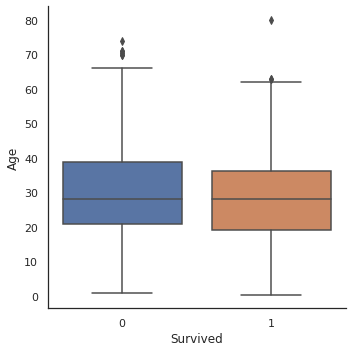

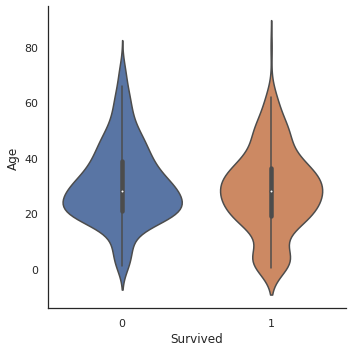

In [36]:
g = sns.catplot(x = 'Survived', y = 'Age', data = train, kind = 'box')
g = sns.catplot(x = 'Survived', y = 'Age', data = train, kind = 'violin')

* 생존자/사망자 간 중앙값의 차이는 없음
* viloin plot을 보았을 때, young passenger의 생존비율이 높다는 것 재확인

##5. Feature engineering

###5.1 Name/Title

In [37]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [38]:
#Get Title from Name
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

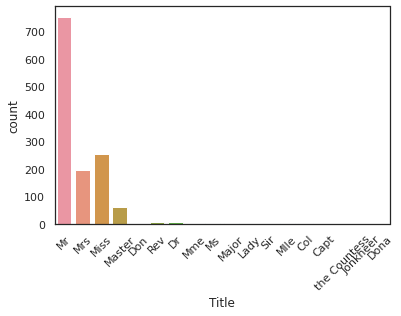

In [39]:
g = sns.countplot(x = 'Title', data = dataset)
g = plt.setp(g.get_xticklabels(), rotation = 45)

In [40]:
#Convert to categorical values Title
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


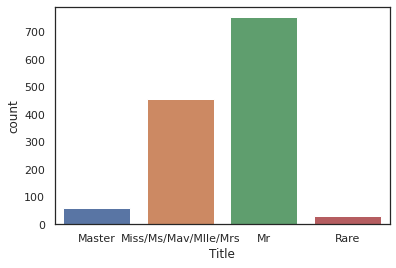

In [41]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss/Ms/Mav/Mlle/Mrs', 'Mr', 'Rare'])

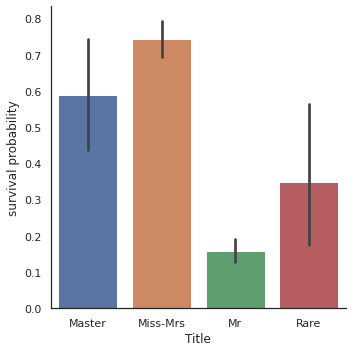

In [43]:
g = sns.catplot(x = 'Title', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('survival probability')

"Women and children first"

* rare한 성? 호칭을 가진 사람들의 생존 비율이 높음

In [44]:
#Drop Name variable
dataset.drop(labels=['Name'], axis = 1, inplace = True)

###5.2 Family size

* 대가족은 이동에 어려움을 겪음
* Fize feature을 새로 만듦 <- family size = the sum of SibSp, Parch and 1

In [45]:
#Create a family size descripor from Sibsp and Parch
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


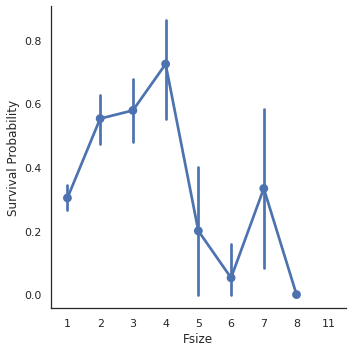

In [49]:
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)   #catplot에서는 왜 안되지?
g = g.set_ylabels("Survival Probability")

* 대가족의 생존비율이 낮다는 점 확인

In [50]:
#Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

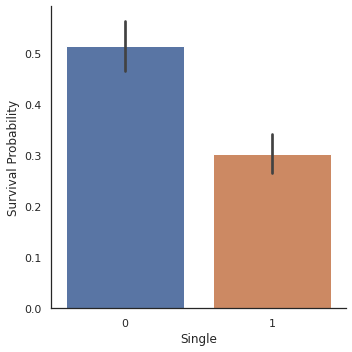

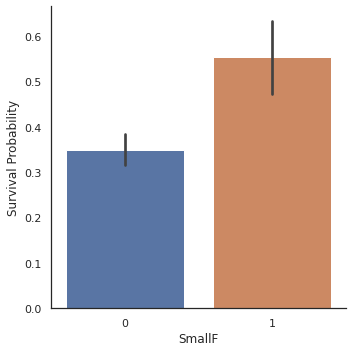

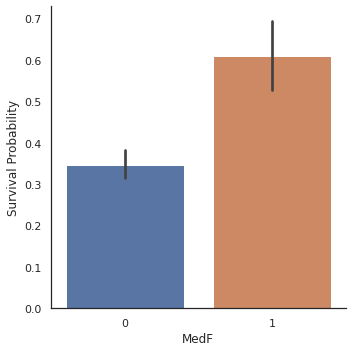

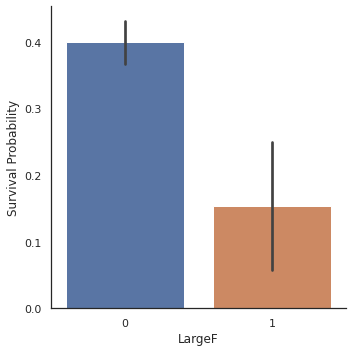

In [51]:
g = sns.catplot(x = 'Single', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')
g = sns.catplot(x = 'SmallF', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')
g = sns.catplot(x = 'MedF', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')
g = sns.catplot(x = 'LargeF', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')

* small and medium families에서 single/large families 보다 더 생존확률이 높았음

In [53]:
#convert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix = 'Em')

In [54]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


### 5.3 Cabin

In [55]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [56]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [58]:
dataset['Cabin'].isnull().sum()

1007

cabin이 없는 passenger가 missing value로 추정됨

In [59]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [60]:
#Replace the Cabin number by the type of cabin 'X' if not
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

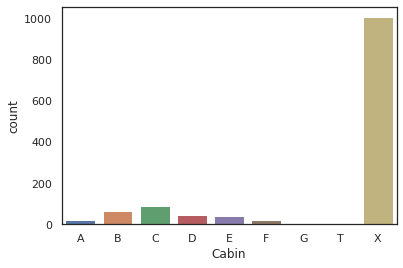

In [62]:
g = sns.countplot(x = dataset['Cabin'], order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

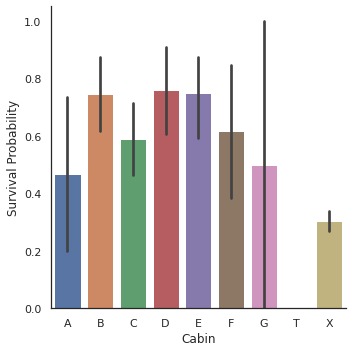

In [63]:
g = sns.catplot(x = 'Cabin', y = 'Survived', data = dataset, kind = 'bar', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])
g = g.set_ylabels('Survival Probability')

* 선실(Cabin)의 수가 적어서 생존확롤의 표준편차를 잘 봐야 됨
* 선실이 있는 passenger는 더 생존확률이 높았음 B, C, D, E, F에서 확인.

In [64]:
dataset = pd.get_dummies(dataset, columns = ['Cabin'], prefix='Cabin')

### 5.4 Ticket

In [65]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

* 같은 접두사를 가진 티켓은 같은 선실을 썼다는 의미
* 실제 선실의 수로 판단 가능

In [66]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace('.', '').replace('/', '').strip().split(' ')[0])    #Take prefix
    else:
        Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [68]:
dataset = pd.get_dummies(dataset, columns = ['Ticket'], prefix = 'T')

In [70]:
#Create categorical values for Pclass
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix = 'Pc')

In [71]:
# Drop useless variables
dataset.drop(labels = ['PassengerId'], axis = 1, inplace = True)

In [72]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


##6. MODELING

In [74]:
##Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis = 1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [75]:
## Separate train features and label

train['Survived'] = train['Survived'].astype(int)
y_train = train['Survived']
X_train = train.drop(labels = ['Survived'], axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


###6.1 Simple modeling

####6.1.1 Cross validate models
* SVC
* Decision Tree
* AdaBoost
* Random Forest
* Extra trees
* Gradient Boosting
* Multiple layer perception (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis

In [84]:
# Cross validate model with Kfold stratifed cross val
kfold = StratifiedKFold(n_splits=10)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


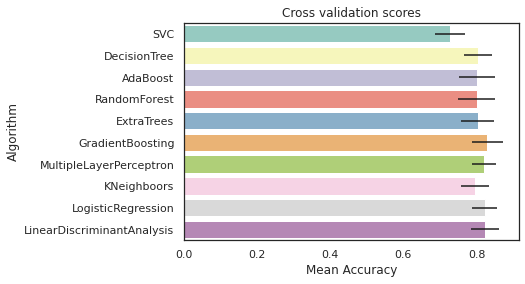

In [80]:
# Modeling step Test differents algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = 'accuracy', cv = Kfold, n_jobs=4))

cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans': cv_means, 'CrossValerrors': cv_std, 
                       'Algorithm': ["SVC", "DecisionTree", "AdaBoost", "RandomForest", "ExtraTrees", "GradientBoosting",
                                     "MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot('CrossValMeans', 'Algorithm', data = cv_res, palette = 'Set3', orient = 'h', **{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross validation scores')

**SVC, AdaBoost, RandomForest, ExtraTrees and GradientBoosting classifiers for the ensemble modeling**

### 6.1.2 Hyperparameter tunning for best models

* grid search optimization

In [87]:
### META MODELING WITH ADABOOST, RANDOM FOREST, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {'base_estimator__criterion': ["gini", "entropy"],
                   'base_estimator__splitter': ["best", "random"],
                   'algorithm': ['SAMME', 'SAMME.R'],
                   'n_estimators': [1, 2],
                   'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]
                   }

gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsadaDTC.fit(X_train, y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [88]:
gsadaDTC.best_score_

0.8275536261491316

In [94]:
#ExtraTrees
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]
              }

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv = kfold, scoring='accuracy', n_jobs = 4, verbose = 1)

gsExtC.fit(X_train, y_train)

ExtC_best = gsExtC.best_estimator_

#Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8308861082737489

In [97]:
# RFC Parameters tunning
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {'max_depth': [None],
                 'max_features': [1, 3, 10],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [False],
                 'n_estimators': [100, 300],
                 'criterion': ['gini']
                 }

gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsRFC.fit(X_train, y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8331460674157304

In [98]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss': ['deviance'],
                 'n_estimators': [100, 200, 300],
                 'learning_rate': [0.1, 0.05, 0.01],
                 'max_depth': [4, 8],
                 'min_samples_leaf': [100, 150],
                 'max_features': [0.3, 0.1]
                 }

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsGBC.fit(X_train, y_train)

GBC_best = gsGBC.best_estimator_

#Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8331332992849847

In [100]:
### SVC classifier

SVMC = SVC(probability = True)
svc_param_grid = {'kernel': ['rbf'],
                  'gamma': [0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100, 200, 300, 1000]
                  }

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsSVMC.fit(X_train, y_train)

SVMC_best = gsSVMC.best_estimator_

#Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

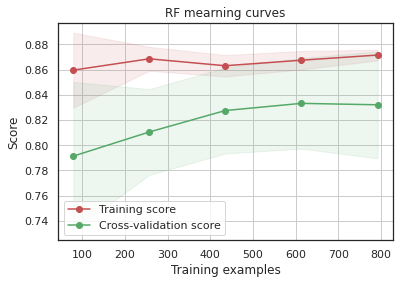

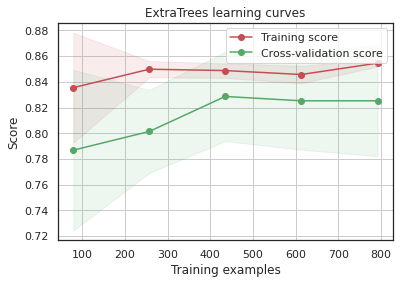

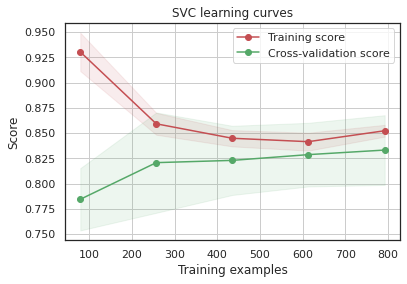

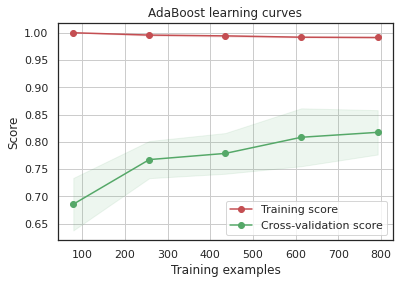

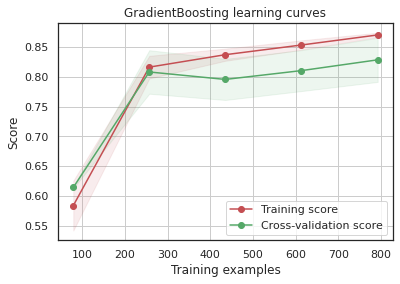

In [102]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train, y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train, y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train, y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train, y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train, y_train,cv=kfold)

* GradientBoosting and Adaboost classifiers는 과대적합하는 경향이 보임
* growing cross-validation curves에 따르면 Gradient Boosting and Adaboost가 더 나음
* SVC랑 ExtraTrees classifiers는 예측을 일반화하는 데 좋아 보임

####6.1.4 Feature importance of tree based classifiers

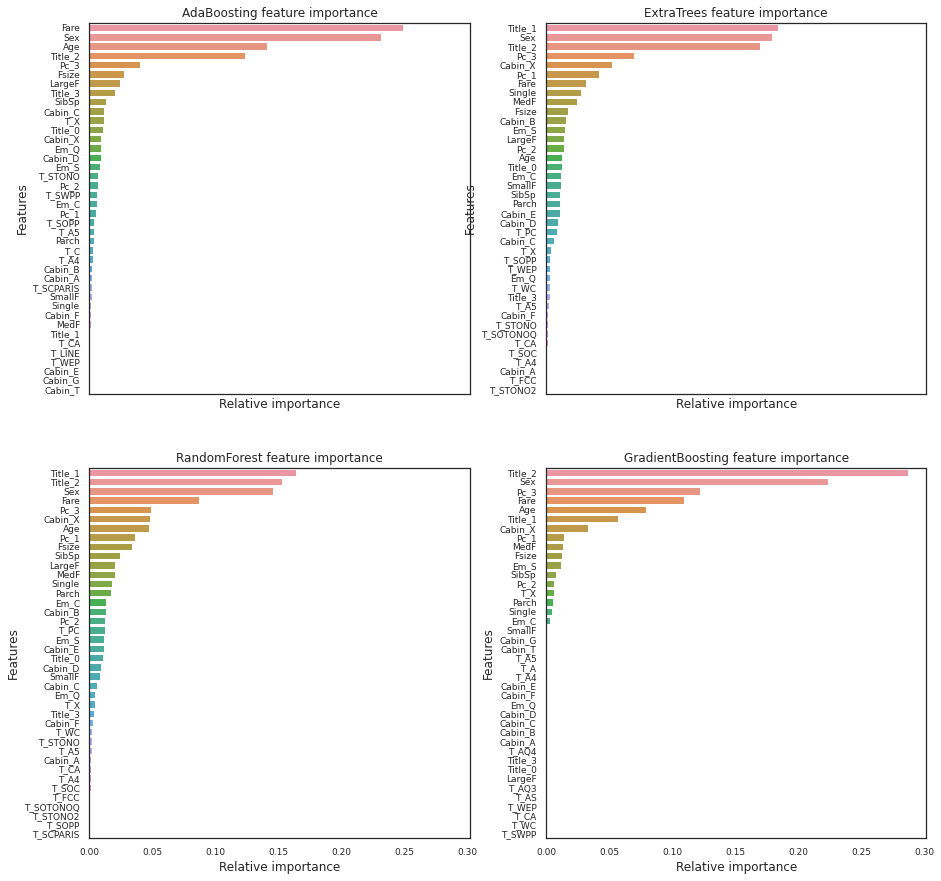

In [103]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , 
                        orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

* top features가 relative importance에 따라 다른 걸 확인
* 이는 예측이 같은 feature를 기반으로 한 것이 아님을 나타냄
* 'Fare', 'Title_2', 'Age', and 'Sex'는 공통으로 중요한 feature

* Title_2는 Sex와 높은 상관관계를 가짐

---------------------------------------------

* Pc_1, Pc_2, Pc_3 and Fare은 기본적인 사회적 지위
* Sex and Title_2, Title_3은 성별
* Age and Title_1은 승객의 나이
* Fsize, LargeF, MedF, Single은 승객 가족의 규모

**위 그래프에 따르면, 생존 예측은 age, sex, family size, and social standing과 관련이 있는 것으로 보임**

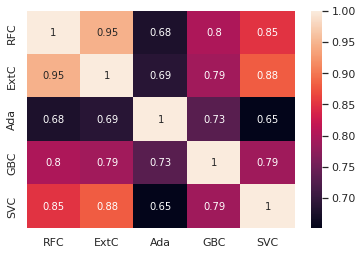

In [104]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

* 이 예측은 Adaboost를 다른 분류기와 비교한 걸 뺀 다섯 개의 분류기와 비슷함
* 5개의 분류기는 비슷한 예측을 보이나 조금 차이가 있음. 이는 앙상블 직접 투표에 고려해 볼 만함

###6.2 Ensemble modeling

####6.2.1 Combining models

In [105]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),('svc', SVMC_best), ('adac',ada_best),
                                       ('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, y_train)

###6.3 Prediction

####6.3.1 Predict and Submit results

In [106]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')

results = pd.concat([IDtest, test_Survived], axis=1)

results.to_csv('ensemble_python_voting.csv', index=False)